# Telephonic Marketing Campaign

### *Dependencies*

In [37]:
# Check Dependencies
from lib_installer import installer
installer()

In [38]:
# Main general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
%matplotlib inline
import os
import seaborn as sns
from collections import Counter

from Log_Progress import log_progress

cwd = os.getcwd()

In [85]:
# Model libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, recall_score, precision_recall_fscore_support, roc_auc_score, \
                            roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc, silhouette_score, calinski_harabasz_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import DBSCAN, KMeans
from sklearn.naive_bayes import BernoulliNB
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

### Introduction to the Problem

A bank company wants to sell a product to its clients and a telephonic marketing campaign is the method chosen. Though this type of campaigns are very successful the company has a problem: The number of clients is too large.

Having to call every client individually, the telephonic campaign would be very resource intensive so they would like to optimize this process. The company wants:
- To reduce the number of calls.
- To ensure that **every call** is successful.

In [40]:
# Load the data
data_train = pd.read_csv(cwd + "/dataset/train.csv", sep=";")
data_train.drop(columns=['ID', 'fecha_contacto'], axis=1, inplace=True)
data_train["educacion"].replace({'priamaria': 'primaria'}, inplace=True)
data_train.head()

,edad,trabajo,estado_civil,educacion,deuda,saldo,vivienda,prestamo,tipo_contacto,duracion,campaign,tiempo_transcurrido,contactos_anteriores,resultado_campanas_anteriores,target
0,40,blue-collar,casado,secundaria/superiores,no,580,si,no,NaN,192,1,-1,0,NaN,no
1,47,services,soltero,secundaria/superiores,no,3644,no,no,NaN,83,2,-1,0,NaN,no
2,25,student,soltero,universitarios,no,538,si,no,movil,226,1,-1,0,NaN,no
3,42,management,casado,universitarios,no,1773,no,no,movil,311,1,336,1,sin_exito,no
4,56,management,casado,universitarios,no,217,no,si,movil,121,2,-1,0,NaN,no


In [41]:
data_test = pd.read_csv(cwd + "/dataset/test.csv",sep=";")
data_test.drop(columns=['ID', 'fecha_contacto'], axis=1, inplace=True)
data_test["educacion"].replace({'priamria': 'primaria'}, inplace=True)
data_test.head()

,edad,trabajo,estado_civil,educacion,deuda,saldo,vivienda,prestamo,tipo_contacto,duracion,campaign,tiempo_transcurrido,contactos_anteriores,resultado_campanas_anteriores,target
0,51,entrepreneur,casado,secundaria/superiores,si,-2082,no,si,movil,123,6,-1,0,NaN,no
1,50,management,casado,universitarios,no,2881,no,no,movil,510,2,2,5,otro,no
2,50,technician,casado,secundaria/superiores,no,1412,no,no,movil,131,3,-1,0,NaN,no
3,37,management,casado,universitarios,no,0,si,no,NaN,247,13,-1,0,NaN,no
4,31,admin.,soltero,secundaria/superiores,no,757,no,no,movil,343,2,-1,0,NaN,no


In [42]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44256 entries, 0 to 44255
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   edad                           44256 non-null  int64 
 1   trabajo                        44256 non-null  object
 2   estado_civil                   44256 non-null  object
 3   educacion                      42446 non-null  object
 4   deuda                          44256 non-null  object
 5   saldo                          44256 non-null  int64 
 6   vivienda                       44256 non-null  object
 7   prestamo                       44256 non-null  object
 8   tipo_contacto                  31526 non-null  object
 9   duracion                       44256 non-null  int64 
 10  campaign                       44256 non-null  int64 
 11  tiempo_transcurrido            44256 non-null  int64 
 12  contactos_anteriores           44256 non-null  int64 
 13  r

### Exploration Data Analysis

First of all, we should scan the data and sort it into different categories to know the clientbase and take better decisions on the following procedures.

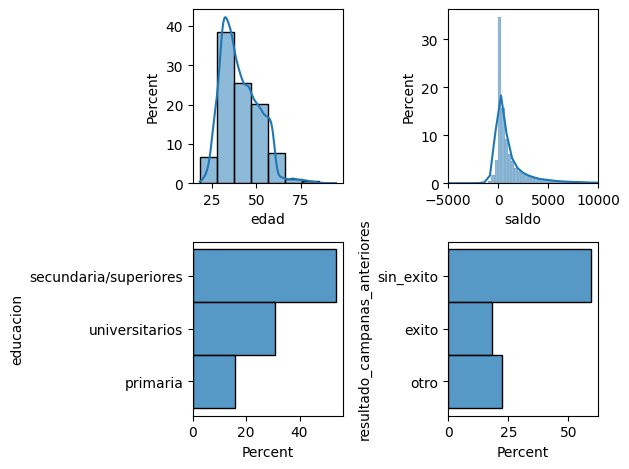

In [43]:
# Distribution of some relevant profiles 
fig0, ax0 = plt.subplots(num=0, nrows=2, ncols=2, tight_layout=True, dpi=100)

bins = int(np.floor(np.sqrt(data_train["edad"].max() - data_train["edad"].min())))
sns.histplot(data=data_train, x="edad", ax=ax0[0, 0], bins=bins, kde=True, stat='percent')

bins = int(np.floor(np.sqrt(data_train["saldo"].max() - data_train["saldo"].min())))
sns.histplot(data=data_train, x="saldo", ax=ax0[0, 1], bins=bins, kde=True, stat='percent')
ax0[0, 1].set_xlim([-5000, 10000]) # Only displaying <10k for visualization purposes

sns.histplot(data=data_train, y="educacion", ax=ax0[1, 0], bins=3, stat='percent')

sns.histplot(data=data_train, y="resultado_campanas_anteriores", ax=ax0[1, 1], bins=3, stat='percent')

plt.show()

### Preparation of the Data

For the models to work we need the data in numerical or boolean type.

In [44]:
# Percentage of missing info in each column
100 * data_train.isnull().sum() / len(data_train)

edad                              0.000000
trabajo                           0.000000
estado_civil                      0.000000
educacion                         4.089841
deuda                             0.000000
saldo                             0.000000
vivienda                          0.000000
prestamo                          0.000000
tipo_contacto                    28.764461
duracion                          0.000000
campaign                          0.000000
tiempo_transcurrido               0.000000
contactos_anteriores              0.000000
resultado_campanas_anteriores    81.713214
target                            0.000000
dtype: float64

To deal with the missing info we will:
- Discard past campaigns results due to the amount of missing information
- Discard the rows that contain missing info in education as they represent only the 4%ish of the dataset
- Discard contact type as it contains too many missing info and it won't be as relevant for the model 

In [45]:
data_train.drop(columns=['resultado_campanas_anteriores', 'tipo_contacto'], axis=1, inplace=True)
data_train.drop(data_train[data_train['educacion'].isnull()].index, inplace=True)
100 * data_train.isnull().sum() / len(data_train)

edad                    0.0
trabajo                 0.0
estado_civil            0.0
educacion               0.0
deuda                   0.0
saldo                   0.0
vivienda                0.0
prestamo                0.0
duracion                0.0
campaign                0.0
tiempo_transcurrido     0.0
contactos_anteriores    0.0
target                  0.0
dtype: float64

In [46]:
# Percentage of missing info in each column
100 * data_test.isnull().sum() / len(data_test)

edad                              0.000000
trabajo                           0.000000
estado_civil                      0.000000
educacion                         4.188246
deuda                             0.000000
saldo                             0.000000
vivienda                          0.000000
prestamo                          0.000000
tipo_contacto                    29.407791
duracion                          0.000000
campaign                          0.000000
tiempo_transcurrido               0.000000
contactos_anteriores              0.000000
resultado_campanas_anteriores    82.053592
target                            0.000000
dtype: float64

In [47]:
# Apply the same processings to the test set
data_test.drop(columns=['resultado_campanas_anteriores', 'tipo_contacto'], axis=1, inplace=True)
data_test.drop(data_test[data_test['educacion'].isnull()].index, inplace=True)
100 * data_test.isnull().sum() / len(data_test)

edad                    0.0
trabajo                 0.0
estado_civil            0.0
educacion               0.0
deuda                   0.0
saldo                   0.0
vivienda                0.0
prestamo                0.0
duracion                0.0
campaign                0.0
tiempo_transcurrido     0.0
contactos_anteriores    0.0
target                  0.0
dtype: float64

In [48]:
X_train, Y_train = data_train.drop(columns='target', axis=1), data_train['target']
X_test, Y_test = data_test.drop(columns='target', axis=1), data_test['target']

Y_train.replace({'no': 0, 'si':1}, inplace=True)
Y_test.replace({'no': 0, 'si':1}, inplace=True)

In [49]:
class Encoder():
    def __init__(self, columns):
        self.freq_dicts = {}
        self.num_df = None
        self.cat_df = None
        self.scaler = None
        self.scale_dicts = {}
        self.df_columns = columns
    
    def frequency(self, df):
        self.num_df = df.select_dtypes(exclude=['object'])
        self.cat_df = df.select_dtypes(include=['object'])
        
        for col in self.cat_df.columns.values:
            freq_dict = (self.cat_df.groupby(col).size() / len(self.cat_df)).to_dict()
            self.cat_df[col].replace(freq_dict, inplace=True)
            self.freq_dicts[col] = freq_dict
        
        df = pd.concat([self.num_df, self.cat_df], axis=1)
        df = df[self.df_columns]
            
        return df
    
    def apply_freq_dict(self, df):
        for col, freq_dict in self.freq_dicts.items():
            df[col].replace(freq_dict, inplace=True)
            
        return df
    
    def scale(self, df):
        self.num_df = df.select_dtypes(exclude=['object'])
        self.cat_df = df.select_dtypes(include=['object'])
        print(self.num_df)
        
        for col in self.cat_df.columns.values:
            self.scaler = MinMaxScaler()
            scale_dict = self.scaler.fit(self.num_df.loc[col])
            self.num_df.loc[:, col] = self.scaler.transform(self.num_df.loc[col])
            self.scale_dicts[col] = scale_dict
        
        df = pd.concat([self.num_df, self.cat_df], axis=1)
        df = df[self.df_columns]
        
        return df
    
    def apply_scaling(self, df):
        for col, scale_dict in self.scale_dicts.items():
            df[col] = scale_dict.transform(df[col])
        
        return df

In [50]:
encoder = Encoder(X_train.columns.values)
X_train = encoder.frequency(X_train) 
X_train.head()

,edad,trabajo,estado_civil,educacion,deuda,saldo,vivienda,prestamo,duracion,campaign,tiempo_transcurrido,contactos_anteriores
0,40,0.213825,0.601164,0.535103,0.98193,580,0.560854,0.835674,192,1,-1,0
1,47,0.092188,0.282500,0.535103,0.98193,3644,0.439146,0.835674,83,2,-1,0
2,25,0.017952,0.282500,0.306860,0.98193,538,0.560854,0.835674,226,1,-1,0
3,42,0.212600,0.601164,0.306860,0.98193,1773,0.439146,0.835674,311,1,336,1
4,56,0.212600,0.601164,0.306860,0.98193,217,0.439146,0.164326,121,2,-1,0


In [51]:
# Apply the same codification to the test set using the dicts generated during the first encoding
X_test = encoder.apply_freq_dict(X_test)
X_test.head()

,edad,trabajo,estado_civil,educacion,deuda,saldo,vivienda,prestamo,duracion,campaign,tiempo_transcurrido,contactos_anteriores
0,51,0.032418,0.601164,0.535103,0.01807,-2082,0.439146,0.164326,123,6,-1,0
1,50,0.212600,0.601164,0.306860,0.98193,2881,0.439146,0.835674,510,2,2,5
2,50,0.169604,0.601164,0.535103,0.98193,1412,0.439146,0.835674,131,3,-1,0
3,37,0.212600,0.601164,0.306860,0.98193,0,0.560854,0.835674,247,13,-1,0
4,31,0.115676,0.282500,0.535103,0.98193,757,0.439146,0.835674,343,2,-1,0


In [52]:
print(encoder.freq_dicts['trabajo'])

{'admin.': 0.11567638882344626, 'blue-collar': 0.21382462422843143, 'entrepreneur': 0.03241766008575602, 'housemaid': 0.02761155350327475, 'management': 0.21259953823681854, 'retired': 0.04952174527635113, 'self-employed': 0.035574612448758425, 'services': 0.09218772086886869, 'student': 0.017952221646327097, 'technician': 0.16960373180040522, 'unemployed': 0.02935494510672384, 'unknown': 0.0036752579748386186}


In [53]:
X_train = encoder.scale(X_train) 
X_train.head()

       edad   trabajo  estado_civil  educacion    deuda  saldo  vivienda   
0        40  0.213825      0.601164   0.535103  0.98193    580  0.560854  \
1        47  0.092188      0.282500   0.535103  0.98193   3644  0.439146   
2        25  0.017952      0.282500   0.306860  0.98193    538  0.560854   
3        42  0.212600      0.601164   0.306860  0.98193   1773  0.439146   
4        56  0.212600      0.601164   0.306860  0.98193    217  0.439146   
...     ...       ...           ...        ...      ...    ...       ...   
44251    38  0.212600      0.601164   0.535103  0.98193   -323  0.560854   
44252    49  0.169604      0.601164   0.535103  0.98193   1982  0.560854   
44253    51  0.213825      0.601164   0.535103  0.98193    794  0.560854   
44254    29  0.213825      0.282500   0.306860  0.98193     98  0.439146   
44255    32  0.169604      0.282500   0.535103  0.98193    321  0.560854   

       prestamo  duracion  campaign  tiempo_transcurrido  contactos_anteriores  
0     

,edad,trabajo,estado_civil,educacion,deuda,saldo,vivienda,prestamo,duracion,campaign,tiempo_transcurrido,contactos_anteriores
0,40,0.213825,0.601164,0.535103,0.98193,580,0.560854,0.835674,192,1,-1,0
1,47,0.092188,0.282500,0.535103,0.98193,3644,0.439146,0.835674,83,2,-1,0
2,25,0.017952,0.282500,0.306860,0.98193,538,0.560854,0.835674,226,1,-1,0
3,42,0.212600,0.601164,0.306860,0.98193,1773,0.439146,0.835674,311,1,336,1
4,56,0.212600,0.601164,0.306860,0.98193,217,0.439146,0.164326,121,2,-1,0


In [54]:
X_test = encoder.apply_scaling(X_test) 
X_test.head()

,edad,trabajo,estado_civil,educacion,deuda,saldo,vivienda,prestamo,duracion,campaign,tiempo_transcurrido,contactos_anteriores
0,51,0.032418,0.601164,0.535103,0.01807,-2082,0.439146,0.164326,123,6,-1,0
1,50,0.212600,0.601164,0.306860,0.98193,2881,0.439146,0.835674,510,2,2,5
2,50,0.169604,0.601164,0.535103,0.98193,1412,0.439146,0.835674,131,3,-1,0
3,37,0.212600,0.601164,0.306860,0.98193,0,0.560854,0.835674,247,13,-1,0
4,31,0.115676,0.282500,0.535103,0.98193,757,0.439146,0.835674,343,2,-1,0


C:\Users\marti\AppData\Local\Temp\ipykernel_9660\3966763062.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_train_treated[f][data_train_treated["target"] == 1], color='green')
C:\Users\marti\AppData\Local\Temp\ipykernel_9660\3966763062.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distpl

C:\Users\marti\AppData\Local\Temp\ipykernel_9660\3966763062.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_train_treated[f][data_train_treated["target"] == 1], color='green')
C:\Users\marti\AppData\Local\Temp\ipykernel_9660\3966763062.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distpl

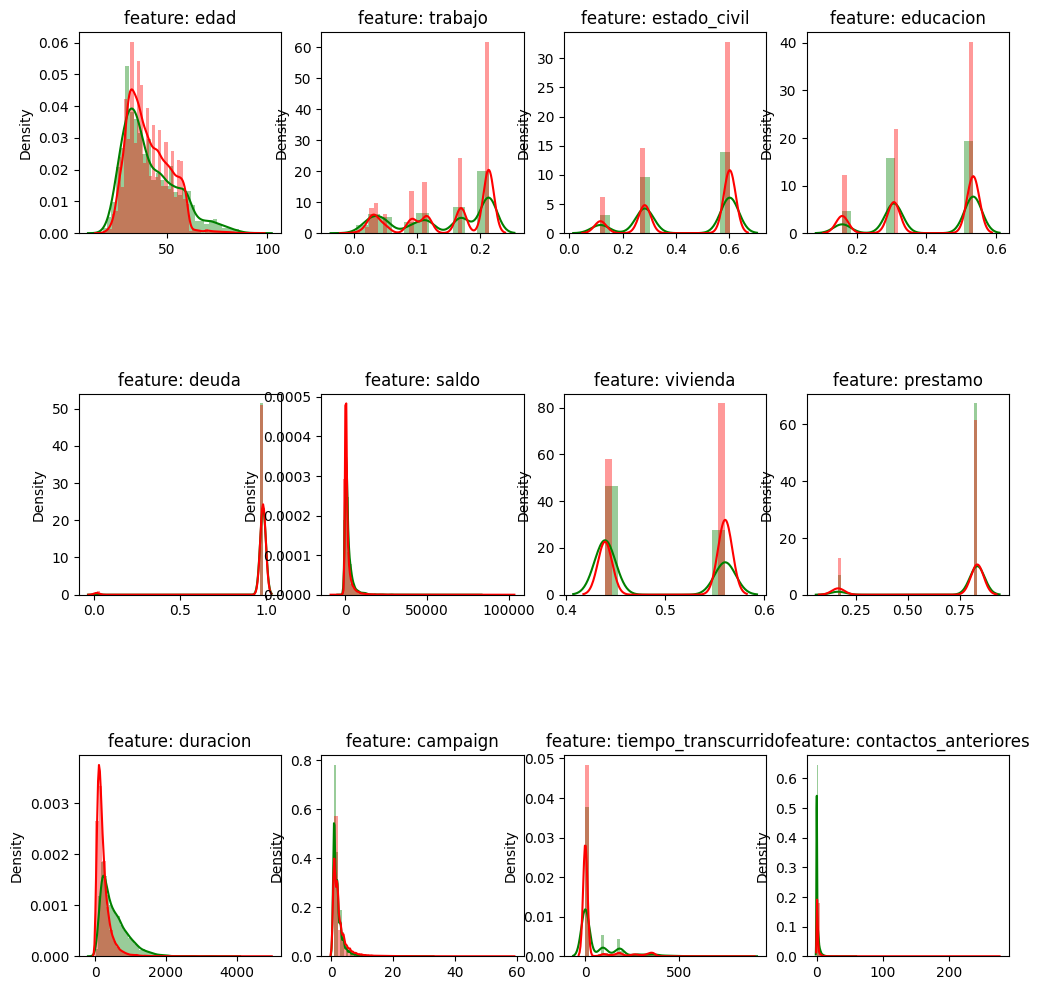

In [55]:
# Representamos gráficamente las características
features = X_train
data_train_treated = pd.concat([X_train, Y_train], axis=1)

plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(3, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(data_train_treated[f][data_train_treated["target"] == 1], color='green')
    sns.distplot(data_train_treated[f][data_train_treated["target"] == 0], color='red')
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

### Data Analysis

Before starting with the modeling process, we should determine and clarify the objective of the final model. Different objectives may yield different models so, as silly as it may seem, this process of objective clarification is the key for a good model. 

To see why this part is so important let's take a look at a simple example. Imagine we have a model to predict if a transaction is legal and we have 10k transactions a day, of which 9.9k are legal and only 0.1k are ilegal transactions. We build a model which predicts that every transaction is legal always and we analyze the results. Of 10k transactions 9.9k were correctly labeled as legal yielding 99% accuracy from the model. That's good right? Of course not, because of 100 ilegal transactions none where caugth.

In this example we can see why choosing the wrong objective can yield to bad models. Accuracy encourages correct labels but when the data is not evenly distributed it becomes a wrong objective.

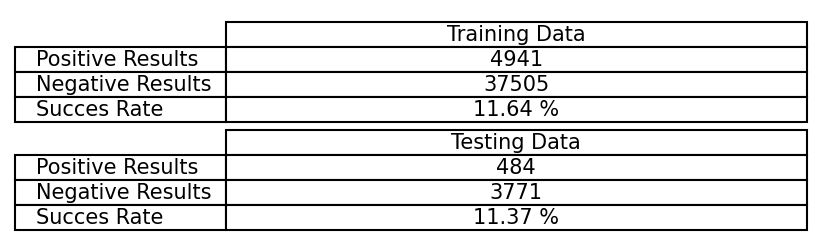

In [56]:
# Scanning of the target
positive_train = Y_train.sum()
total_train = Y_train.size
positive_test = Y_test.sum()
total_test = Y_test.size
row_labels = ['Positive Results', 'Negative Results', 'Succes Rate']
target_data_train = [[positive_train], [total_train - positive_train], [f'{100 * positive_train/total_train:.2f} %']]
target_data_test = [[positive_test], [total_test - positive_test], [f'{100 * positive_test/total_test:.2f} %']]

fig1, ax1 = plt.subplots(figsize=(5, 1), num=1, dpi=150)
ax1.axis('off')
ax1.axis('tight')
ax1.table(colLabels=['Training Data'], rowLabels=row_labels, cellText=target_data_train, loc='center', cellLoc='center')
ax1.table(colLabels=['Testing Data'], rowLabels=row_labels, cellText=target_data_test, loc='bottom', cellLoc='center')
plt.show()

In [57]:
# concatenate our training data back together
df_xy = pd.concat([X_train, Y_train], axis=1)

# Display distribution
print ('\033[1m', 'Before downsampling', '\033[0m')
print(df_xy['target'].value_counts() )

df_majority = df_xy[df_xy['target']==0]
df_minority = df_xy[df_xy['target']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,     # sample without replacement
                                   n_samples=len(df_minority),  # to match minority class
                                   random_state=1234) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print ('\n', '\033[1m', 'After downsampling', '\033[0m', )
df_downsampled['target'].value_counts()

 Before downsampling 
target
0    37505
1     4941
Name: count, dtype: int64

  After downsampling 


target
0    4941
1    4941
Name: count, dtype: int64

C:\Users\marti\AppData\Local\Temp\ipykernel_9660\462189864.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_downsampled[f][df_downsampled["target"] == 1], color='green')
C:\Users\marti\AppData\Local\Temp\ipykernel_9660\462189864.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_down

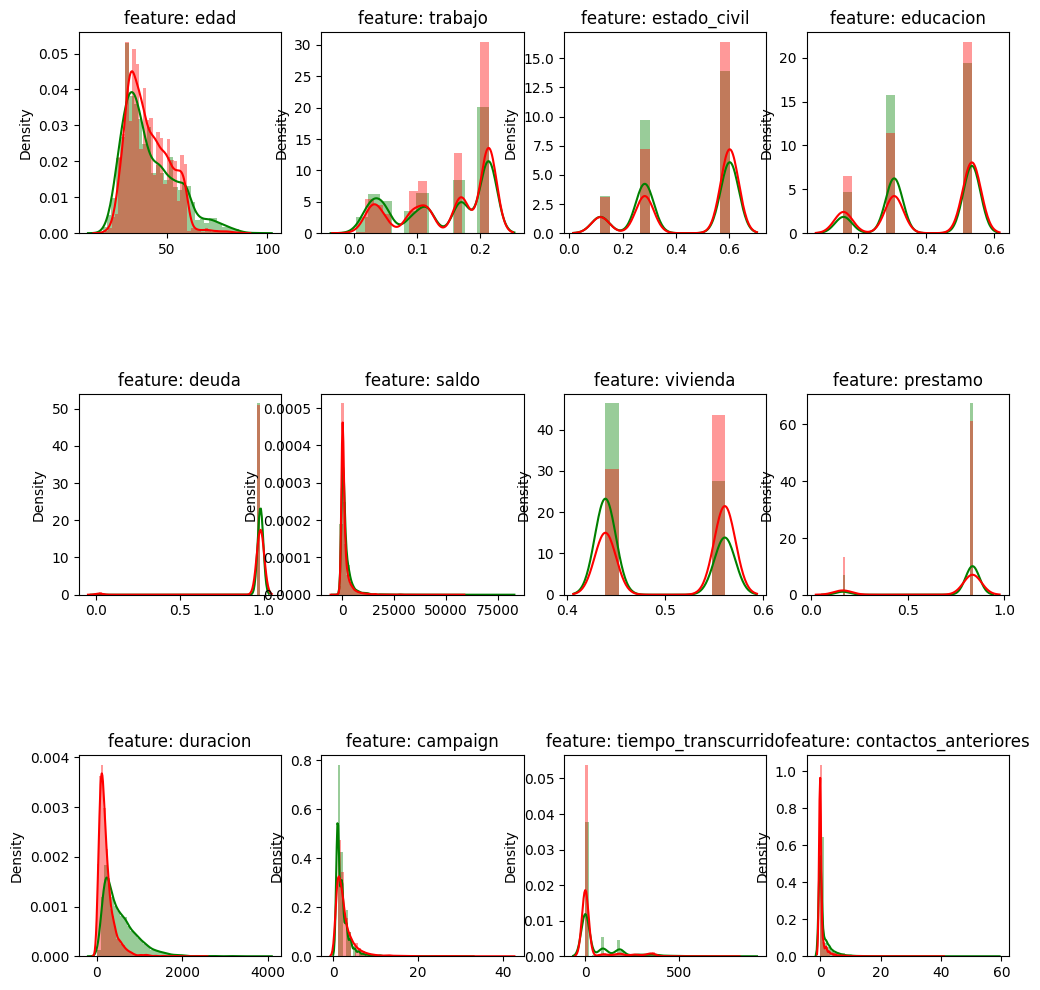

In [58]:
# Representamos gráficamente las características
features = df_downsampled.drop("target", axis=1)

plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(3, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df_downsampled[f][df_downsampled["target"] == 1], color='green')
    sns.distplot(df_downsampled[f][df_downsampled["target"] == 0], color='red')
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

In [59]:
X_train_ds, Y_train_ds = df_downsampled.drop(columns='target', axis=1), df_downsampled['target']

As seen in the quick examination above only 11.7% is considered a positive result so we conclude that the data is unevenly distributed. Thus, a downsampling has been applied to the training dataset to even out the target and not bias our model.

Now it's time to choose a good objective. Let's sum up some of the most common objectives used and choose between one of them:
- Accuracy (defined as $\frac {Correct Predictions} {Total Predictions}$): Most of the **data** will be correctly classified.

- Precision (defined as $\frac {Correct Positive Predictions} {Total Positive Predictions}$): Reduces the **false positive** cases.

- Recall/Sensitivity (defined as $\frac {Correct Positive Predictions} {Real Positives}$): Most of the **real positive** cases will be correctly classified. **False positive** cases are in consequence increased.

- F1 Score (defined as $\frac {2·Precision·Recall} {Precision + Recall}$): It's the harmonic average of precision and recall.

To choose the correct objective lets review what do we want to achieve:
- *We have too many clients and we wanted to optimize our workers' time. We want to call **only** the people susceptive to buy the offer*

As we want that ideally every client called buys the offer, **PRECISION** is the best choice as it will reduce the number of calls that yield negative results.

### KMeans Model

In [ ]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    matrix = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(matrix, axis=0)) / np.sum(matrix)

In [68]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_train)

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [69]:
counter = Counter(clusters.tolist())
success_counter = Counter(clusters[Y_train == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are success samples".format(
        key, counter[key], success_counter[key]))

Label 0 has 487 samples - 276 are success samples
Label 1 has 9395 samples - 4665 are success samples


In [65]:
# Calculamos el purity score, es importante darse cuenta de que recibe las etiquetas
print("Purity Score:", purity_score(Y_train, clusters))
# Calculamos el coeficiente de Shiloutte, es importante darse cuenta de que no le pasamos las etiquetas
print("Shiloutte: ", silhouette_score(X_train, clusters, sample_size=10000))
# Calculamos el Calinski harabasz score, es importante darse cuenta de que no le pasamos las etiquetas
print("Calinski harabasz: ", calinski_harabasz_score(X_train, clusters))

Purity Score: 0.8835932714507845
Shiloutte:  0.6852353502684393
Calinski harabasz:  80493.292889198


### DBScan Model

In [72]:
dbscan = DBSCAN(eps=0.7, min_samples=25)
dbscan.fit(X_train)

clusters = dbscan.labels_

In [73]:
counter = Counter(clusters.tolist())
success_counter = Counter(clusters[Y_train == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are success samples".format(
        key, counter[key], success_counter[key]))

Label -1 has 42446 samples - 4941 are success samples


In [ ]:
# Calculamos el purity score, es importante darse cuenta de que recibe las etiquetas
print("Purity Score:", purity_score(Y_train, clusters))
# Calculamos el coeficiente de Shiloutte, es importante darse cuenta de que no le pasamos las etiquetas
print("Shiloutte: ", silhouette_score(X_train, clusters, sample_size=10000))
# Calculamos el Calinski harabasz score, es importante darse cuenta de que no le pasamos las etiquetas
print("Calinski harabasz: ", calinski_harabasz_score(X_train, clusters))

### Naive Bayes Model

In [84]:
nb_clf = BernoulliNB(alpha=1.0e-10)
nb_clf.fit(X_train, Y_train)
Y_pred = nb_clf.predict(X_test)
print(Y_pred.sum())
print('F1 score: {:.2f}%'.format(100 * f1_score(Y_test, Y_pred)))

0
F1 score: 0.00%


### Gaussian Distribution Model

In [102]:
gm = GaussianMixture(n_components=2, random_state=42)
gm.fit(X_train_ds)

GaussianMixture(n_components=2, random_state=42)

In [104]:
# Selección del Threshold
densities = gm.score_samples(X_train_ds)
density_threshold = np.percentile(densities, 0.1)
print("Threshold seleccionado:", density_threshold)
# Identificación de anomalías
anomalies = X_train_ds.values[densities < density_threshold]

Threshold seleccionado: -88.74875410901512


In [105]:
# Comparación de cuantas anomalías se correspondían con ejemplos fraudulentos
Y_preds = (densities < density_threshold)
Y_preds[Y_preds == False] = 0
Y_preds[Y_preds == True] = 1
# Casos identificados como anomalías etiquetados como negativos (0) y positivos (1)
Y_train_ds[Y_preds==1].value_counts()

target
1    7
0    3
Name: count, dtype: int64

In [106]:
from sklearn.base import BaseEstimator

class GaussianAnomalyDetector(BaseEstimator):
    def __init__(self, threshold=1):
        self._threshold = threshold
        self._gm = None
    def fit(self, X, y=None):
        self._gm = GaussianMixture(n_components=2, n_init=10, random_state=42)
        self._gm.fit(X) 
        return self
    
    def predict(self, X, y=None):
        densities = self._gm.score_samples(X)
        y_preds = (densities < self._threshold)
        y_preds[y_preds == False] = 0
        y_preds[y_preds == True] = 1
        return y_preds
    
    def get_params(self, deep=True):
        return {"threshold": self._threshold}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
            return self

In [107]:
def select_threshold(list_thds, densities, y):
    best_prec = 0
    best_threshold = 0
    i = 0
    for thd in list_thds:
        i += 1
        print("\rSearching best threshold {0}%".format(
            int((i + 1) / len(list_thds) * 100)), end='')
        preds = (densities < thd)
        preds[preds == False] = 0
        preds[preds == True] = 1
        precision = precision_score(y, preds)
        if precision > best_prec:
            best_prec = precision
            best_threshold = thd
    return (best_prec, best_threshold)

In [108]:
best_pre, best_thresh = select_threshold(np.arange(-600, -300, 1), densities, Y_train_ds)
print("\n", best_pre, best_thresh)

Searching best threshold 35%

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marti\AppData\Local

Searching best threshold 100%
 0 0


c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marti\AppData\Local

In [110]:
# Comparación de cuantas anomalías se correspondían con ejemplos fraudulentos
Y_preds = (densities < best_thresh)
Y_preds[Y_preds == False] = 0
Y_preds[Y_preds == True] = 1
# Casos identificados como anomalías etiquetados como negativos (0) y positivos (1)
Y_train_ds[Y_preds==1].value_counts()

target
0    4941
1    4941
Name: count, dtype: int64

### Random Forest Model

Once the tree model is trained, the predictions become determinate giving each parameter the same weight in each prediction. One way to mitigate this efect is to create a *'council'* of tree models, each trained with different characterstics of the dataset, that will *'vote'* in every prediction. The label with the most votes (majority in our case because there is only two labels) will be the resulting prediction. As each tree of this *'coucil'* weights each characteristic in a different way we reduce the chance of biasing the model. 
Let's start by building a basic model to discuss some properties:

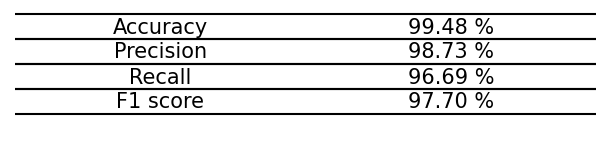

In [ ]:
# Training a random forest model
seed = 42 # Set seed for reproducibility
rf_model = RandomForestClassifier(max_features=5, n_estimators=20, random_state=seed)
rf_model.fit(X_train, Y_train)

rf_predictions = rf_model.predict(X_test)

score_titles = ["Accuracy", "Precision", "Recall", "F1 score"]
rf_scores = accuracy_score(Y_test, rf_predictions), precision_score(Y_test, rf_predictions), recall_score(Y_test, rf_predictions), f1_score(Y_test, rf_predictions)

fig2, ax2 = plt.subplots(figsize=(5, 0.1), num=10, dpi=150)
ax2.axis('off')
ax2.axis('tight')
ax2.table(cellText=[[score_titles[i], f'{100 * v:.2f} %'] for i, v in enumerate(rf_scores)], loc='top', cellLoc='center', edges='horizontal')
plt.show()

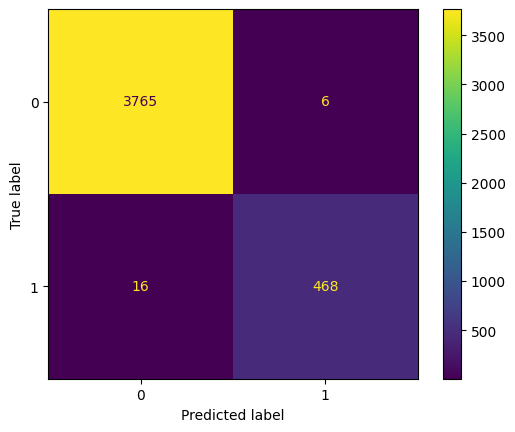

In [ ]:
# Calculate the tree model confusion martix
rf_confusion_matrix = confusion_matrix(Y_test, rf_predictions)
ConfusionMatrixDisplay(rf_confusion_matrix).plot()
plt.show()

As we can see performs very well with a 98.8% precision, but we can do a bit better. First lets see how each category impacts the final result. Then we can sort the categories by relevance and use only the ones that are the most impactful.

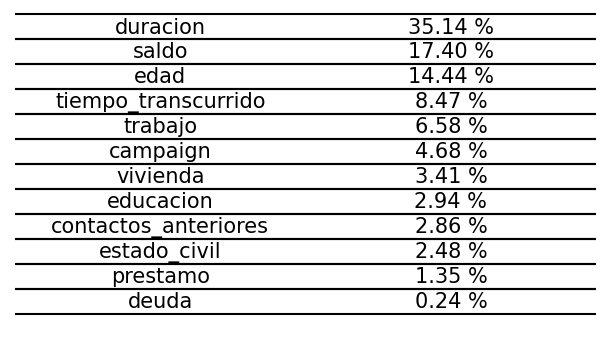

In [ ]:
# Looking for the most impactful characteristics
def takeSecond(elem):
    return elem[1]

fig3, ax3 = plt.subplots(figsize=(5, 0.1), num=3, dpi=150)
feature_importances_sorted = sorted(zip(X_train.columns.values, rf_model.feature_importances_), reverse=True, key=takeSecond)
feature_importances = [[i[0], f'{100 * i[1]:.2f} %'] for i in feature_importances_sorted]
ax3.axis('off')
ax3.axis('tight')
ax3.table(cellText=feature_importances, loc='top', cellLoc='center', edges='horizontal')
plt.show()

In [ ]:
def prepare_data(categories):
    train = X_train[categories]
    test = X_test[categories]
    return (train, test)

In [ ]:
# Testing performance using different features
feature_names_sorted = [i[0] for i in feature_importances_sorted]
precision_features = np.array([])

for i in range(len(feature_names_sorted) - 1):
    train, test = prepare_data(feature_names_sorted[:i+1])
    rf_model = RandomForestClassifier(max_features=5, n_estimators=20, random_state=seed)
    rf_model.fit(train, Y_train)

    rf_predictions = rf_model.predict(test)

    rf_scores = accuracy_score(Y_test, rf_predictions), precision_score(Y_test, rf_predictions), recall_score(Y_test, rf_predictions), f1_score(Y_test, rf_predictions)
    precision_features = np.append(precision_features, rf_scores[1])

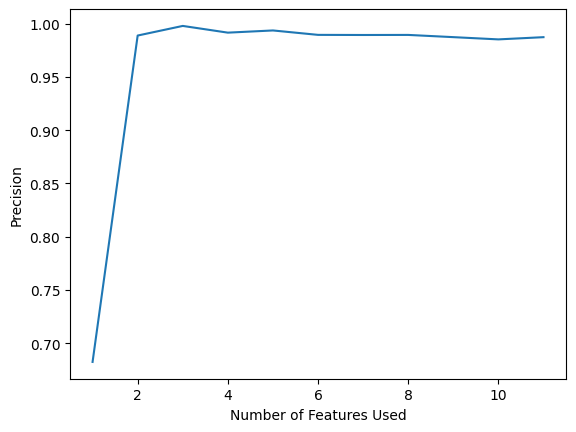

In [ ]:
fig4, ax4 = plt.subplots(num=4)
ax4.set_ylabel('Precision')
ax4.set_xlabel('Number of Features Used')
ax4.plot(np.arange(len(precision_features)) + 1, precision_features)
# ax4.set_ylim(0.9, 1)
plt.show()

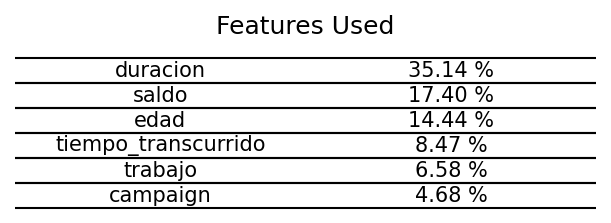

In [ ]:
fig5, ax5 = plt.subplots(figsize=(5, 0.1), num=5, dpi=150)
feature_importances = [[i[0], f'{100 * i[1]:.2f} %'] for i in feature_importances_sorted[:6]]
ax5.set_title('Features Used')
ax5.axis('off')
ax5.axis('tight')
ax5.table(cellText=feature_importances, loc='bottom', cellLoc='center', edges='horizontal')
plt.show()

As seen in the lasts figures, once we have used 6 features (relevance > 5%) the precision stabilizes around 97% (and even starts decaying).
Also we will avoid using de 'Duration' data as it will influence the model too much and produce bias. 

So from now on, to train the next random forest models we will only use these 5 most relevant features excluding 'duration'.

Now it is time to look for the best parameters for our model. This precedure is necessary not only to avoid low precision models (meaning 90% or less in our case) but to avoid the contrary, overfitting.

In [ ]:
used_features_rf = feature_names_sorted[:6]
X_train_rf , X_test_rf = prepare_data(used_features_rf)

In [ ]:
# Scanning for the best parameters of the random forest model WITH KFold cross validation
rf_test_model = RandomForestClassifier(random_state=seed)
possible_params = {'max_features':[3, 5, 7], 'n_estimators': [10, 25, 50, 75, 100]}
grid_search_rf = GridSearchCV(rf_test_model, possible_params, scoring='precision', cv=2)
grid_search_rf.fit(X_train_rf, Y_train)
best_params_rf = grid_search_rf.best_params_

In [ ]:
# Calculating the elbow graph (precision vs n_estimators)
rf_elbow_model = RandomForestClassifier(random_state=seed)
elbow_params = {'n_estimators': range(1, 75, 5)}
grid_search_rf_elbow = GridSearchCV(rf_elbow_model, elbow_params, scoring='precision', cv=2)
grid_search_rf_elbow.fit(X_train_rf, Y_train)
best_params_rf_elbow = grid_search_rf_elbow.best_params_

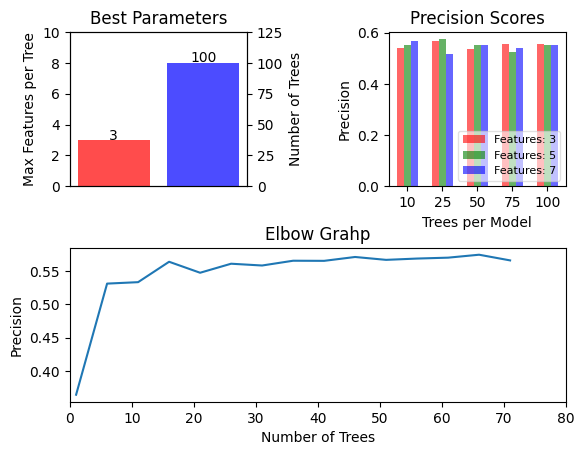

In [ ]:
# Plot of the afforementioned scan
ax9 = np.zeros(3, dtype=object)
fig9 = plt.figure(num=9, dpi=100)

gs = mpl.gridspec.GridSpec(2, 2, wspace=0.8, hspace=0.4)
ax9[0] = fig9.add_subplot(gs[0, 0])
ax9[1] = fig9.add_subplot(gs[0, 1])
ax9[2] = fig9.add_subplot(gs[1, :])

ax9[0].set_title('Best Parameters')
ax9[0].set_ylabel('Max Features per Tree')
ax9[0].bar(0, list(best_params_rf.values())[0], align='center', color='r', alpha = 0.7)
ax9[0].set_xticks(range(len(best_params_rf)), list(best_params_rf.keys()))
ax9[0].set_ylim(0, 10)
ax9[0].xaxis.set_visible(False)
ax9[0].text(0, list(best_params_rf.values())[0], list(best_params_rf.values())[0], ha = 'center')

ax90 = ax9[0].twinx()
ax90.set_ylabel('Number of Trees')
ax90.bar(1, list(best_params_rf.values())[1], align='center', color='b', alpha = 0.7)
ax90.set_ylim(0, 125)
ax90.text(1, list(best_params_rf.values())[1] + 1, list(best_params_rf.values())[1], ha = 'center') 

scores = grid_search_rf.cv_results_['mean_test_score'].reshape(5, 3).T
ax9[1].set_title('Precision Scores')
index = np.arange(5)
bar_width = 0.2
features_3 = ax9[1].bar(index, scores[0], bar_width, color='r', alpha = 0.6, label='Features: 3')
features_5 = ax9[1].bar(index + bar_width, scores[1], bar_width, color='g', alpha = 0.6, label='Features: 5')
features_7 = ax9[1].bar(index + 2*bar_width, scores[2], bar_width, color='b', alpha = 0.6, label='Features: 7')
ax9[1].set_xlabel('Trees per Model')
ax9[1].set_ylabel('Precision')
ax9[1].set_xticks(index + bar_width, ('10', '25', '50', '75', '100'))
# ax9[1].set_ylim(0.55, 0.65)
ax9[1].legend(loc='lower right', framealpha=0.6, fontsize='8')

ax9[2].set_title('Elbow Grahp')
ax9[2].plot(elbow_params['n_estimators'], grid_search_rf_elbow.cv_results_['mean_test_score'])
ax9[2].set_xlabel("Number of Trees")
ax9[2].set_ylabel("Precision")
ax9[2].set_xlim(0, 80)
# ax9[2].set_ylim(0.4, 0.7)

plt.show()

Looking at the last results, the best number of trees should lie around 20-30 trees as seen in the *'elbow'* graph. At this point the precision only enhances slightly probably due to some overfitting. Reducing the number of trees of a random forest model is good for training times and avoid overfitting. We will use then 3 features per tree, 30 trees in total and train it with only the relevant categories found before.

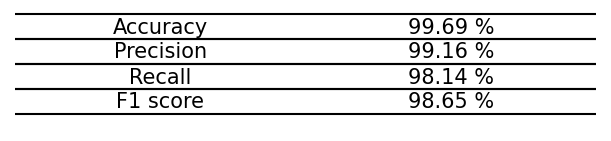

In [ ]:
# Training a random forest model with the best parameters found before and only the most relevant features
max_features, n_estimators = 3, 30
rf_model = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators, random_state=seed)
rf_model.fit(X_train_rf, Y_train)

rf_predictions = rf_model.predict(X_test_rf)

rf_scores = accuracy_score(Y_test, rf_predictions), precision_score(Y_test, rf_predictions), recall_score(Y_test, rf_predictions), f1_score(Y_test, rf_predictions)

fig10, ax10 = plt.subplots(figsize=(5, 0.1), num=10, dpi=150)
ax10.axis('off')
ax10.axis('tight')
ax10.table(cellText=[[score_titles[i], f'{100 * v:.2f} %'] for i, v in enumerate(rf_scores)], loc='top', cellLoc='center', edges='horizontal')
plt.show()

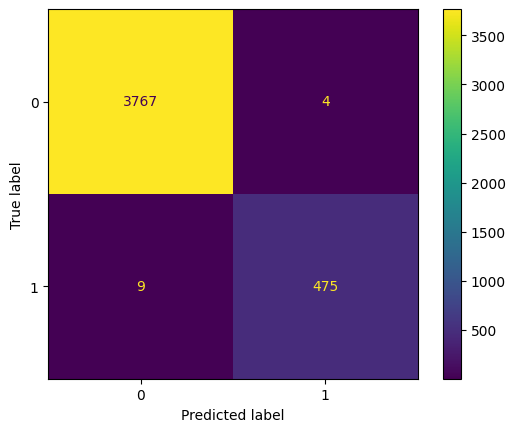

In [ ]:
# Calculate the tree model confusion martix
rf_confusion_matrix = confusion_matrix(Y_test, rf_predictions)
ConfusionMatrixDisplay(rf_confusion_matrix).plot()
plt.show()

Inspecting the results, one can see how the model has tried to maximize the precision as discussed in the first section but at cost of some people who would have bought the poroduct beeing left out.  

**Note:** As one can see inspecting the results, when looking for the best parameters for the random forest model the evaluation got ALL the possible configurations around 40% of precision but the model performed with a 99.8% on the test dataset. Why is that? At first it can seem that something is wrong but further analysis shows that these models from the parameter testing perform almost as well on the test dataset. Testing models got trained with 35k datapoints (approximately), a bit less than the resulting model (which got around 44k), hence the sligthly lower performance over the test dataset. 
To explain the difference of performance between the test split and the test dataset various factors can interfere:
- Hard/Easy datasets: It could have happened that the training set is what is called a *'hard'* dataset and the test dataset might be an *'easy'* dataset. One may think of a hard dataset as one with a lot of variance or low correlation between the categories and the target.
- Luck: It could have happened that the splits were not selected properly biasing the results. Increasing the cross validation splits leads to similiar results taking luck out of the equation.
- Data leakage: It could have happened that many data from the test dataset is repeated in the train dataset, fakely enhancing the model performance.

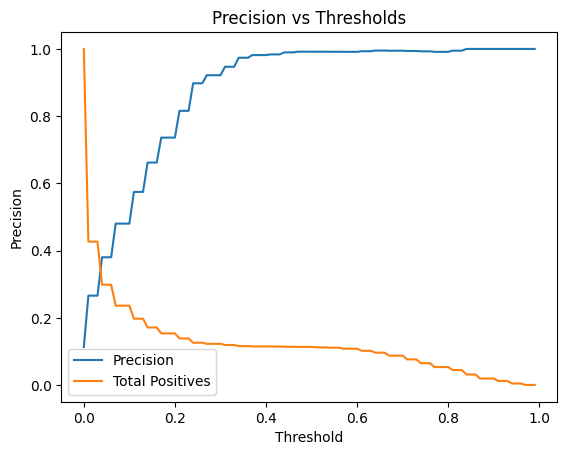

In [ ]:
# Calculating the elbow graph (precision vs thresholds)
rf_model = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators, random_state=seed)
rf_model.fit(X_train_rf, Y_train)
thresholds = np.arange(0, 100) / 100
precision = []
total_pos = []
predicted_proba = rf_model.predict_proba(X_test_rf)

for th in log_progress(thresholds, every=1, name='Thresholds Applied'):
    predicted = (predicted_proba [:,1] >= th).astype('int')
    total_pos.append(predicted.sum())
    correct_pos = (predicted * Y_test).sum()
    precision.append(correct_pos/total_pos[-1])

fig5, ax5 = plt.subplots(num=5)

# x = predicted_proba * Y_test
# ax5.hist(x, density=True, histtype='barstacked', rwidth=0.8)
# ax5.hist(w, density=True, histtype='barstacked', rwidth=0.8)

ax5.set_title('Precision vs Thresholds')
ax5.plot(thresholds, precision, label='Precision')
ax5.plot(thresholds, total_pos/max(total_pos), label='Total Positives')
ax5.set_xlabel("Threshold")
ax5.set_ylabel("Precision")
ax5.legend()
plt.show()

### Evaluating the Model

Now that we tested some parameters and found the best performing ones we have to evaluate the results and conclusions presented beforehand. We will start producing different models with diferent thresholds (separator value) and plotting a *'Receiver operating characteristic'* (ROC for short) of the **'sensitivity'** versus the **'specificity'**

As a reminder:
- Sensitivity (or recall) is calculated as $\frac {Correct Possitives} {Real Positives} = \frac {TP} {TP + FN}$

- Specificity is calculated as $\frac {Correct Negatives} {Real Negatives} = \frac {TN} {TN + FP}$

(As one can see these two metrics are complementary in the confusion matrix)

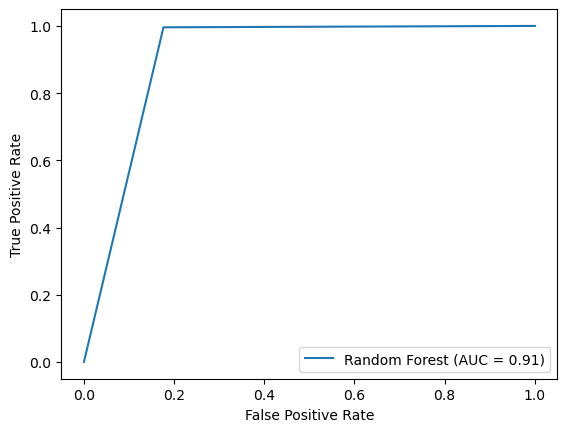

In [ ]:
# Comparison of the models
rf_pred = rf_model.predict(X_test_rf)
fpr, tpr, thresholds = roc_curve(Y_test, rf_pred)
roc_auc = auc(fpr, tpr)

roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')
roc.plot()
plt.show()